# Motor HNN Analysis 

In [1]:
import math
import numpy as np
import torch, sys, io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits import mplot3d 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython import display
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-machine'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset, get_dataset_split, get_dataset_range
from nn_models import MLPAutoencoder, MLP
from hnn import HNN, PixelHNN
from utils import integrate_model

In [2]:
def get_args(speed, folder='NORMAL', latent_cc_pairs=1, scaled=False, split_data=250000, just_hnn=False, ae_path='motor-NORMAL-14-1-pairs'):
    return {'input_dim': 2,
         'input_dim_ae': 8,
         'hidden_dim': 200,
         'latent_dim': latent_cc_pairs,
         'output_dim': 2,
         'ae_path':ae_path,
         'learn_rate': 1e-3,
         'nonlinearity': 'tanh',
         'total_steps': 5000,
         'print_every': 500,
         'name': 'machine-vibration',
         'seed': 0, 
         'save_dir': './{}/saved_models'.format(EXPERIMENT_DIR),
         'fig_dir': './figures',
         'speed': speed,
         'folder': folder,
         'scaled': scaled,
         'split_data': split_data,
         'just_hnn': just_hnn}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

In [3]:
def load_model(args):
    if args.just_hnn:
        nnmodel = MLP(args.input_dim,args.hidden_dim,args.output_dim)
        model = HNN(2, nnmodel)
    else:
        autoencoder = MLPAutoencoder(args.input_dim_ae, args.hidden_dim,
                                         args.latent_dim * 2, nonlinearity='relu')
        model = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder,
                         nonlinearity=args.nonlinearity)
    fixed = '-scaled' if args.scaled else ''
    just_hnn = '-hnn-{}'.format(args.ae_path) if args.just_hnn else ''
    partial = '-{}-datapoints'.format(args.split_data) if args.split_data != 250000 else ''
    folder=args.folder
    folder=folder.replace('/','')
    path = "{}/motor-{}-{}-{}-pairs{}{}{}.tar".format(args.save_dir, folder, args.speed, args.latent_dim, 
                                                      fixed, partial, just_hnn)
    model.load_state_dict(torch.load(path))
    model = model.eval()
    return model

def load_model_col(args, col):
    input_dim=[1,3,3,1][col]
    if args.just_hnn:
        nnmodel = MLP(args.input_dim,args.hidden_dim,args.output_dim)
        model = HNN(2, nnmodel)
    else:
        autoencoder = MLPAutoencoder(input_dim, args.hidden_dim,
                                         args.latent_dim * 2, nonlinearity='relu')
        model = PixelHNN(args.latent_dim * 2, args.hidden_dim, autoencoder,
                         nonlinearity=args.nonlinearity)
    fixed = '-scaled' if args.scaled else ''
    split = '-{}-datapoints'.format(args.split_data) if args.split_data != 250000 else ''
    subcol = ['v', 'a1', 'a2', 's'][col]
    folder=args.folder
    folder=folder.replace('/','')
    just_hnn = '-hnn-{}'.format(args.ae_path) if args.just_hnn else ''
    path = "{}/motor-{}-{}-{}-pairs{}{}-{}{}.tar".format(args.save_dir, folder, args.speed,
                                                                     args.latent_dim, fixed, split, subcol, just_hnn)
    model.load_state_dict(torch.load(path))
    model = model.eval()
    return model

def load_model_all_col(args):
    modela1 = load_model_col(args, 1)
    modela2 = load_model_col(args, 2)
    models = load_model_col(args, 3)
    return modela1, modela2, models

In [4]:
def get_field(model, xmin=-.25, xmax=.25, ymin=-.25, ymax=.25, gridsize=20):
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1, 2)
        dx = model.time_derivative(x).data.numpy().reshape(-1)
        return dx
    
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])

    # get vector directions
    dydt = [fun(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [5]:
def get_params(args, column=False):
    label=args.folder
    if not column:
        model=load_model(args)
    else:
        model=load_model_col(args, column)
    params=model.state_dict()
    params=list(model.parameters())
    return label, params

In [6]:
def get_all_folders():
    subfolders = {'normal':None, 
    'imbalance':['10g', '15g', '20g', '25g', '30g', '35g', '6g'], 
    'overhang':{'ball_fault':['0g', '20g', '35g', '6g'], 'cage_fault':['0g', '20g', '35g', '6g'], 'outer_race':['0g', '20g', '35g', '6g']}, 
    'underhang':{'ball_fault':['0g', '20g', '35g', '6g'], 'cage_fault':['0g', '20g', '35g', '6g'], 'outer_race':['0g', '20g', '35g', '6g']}, 
    'horizontal-misalignment':['0.5mm', '1.0mm', '1.5mm', '2.0mm'],
    'vertical-misalignment':['0.51mm', '0.63mm', '1.27mm', '1.40mm', '1.78mm', '1.90mm']
             }
    folders=[]
    for sub1 in subfolders:
        subfolder=subfolders[sub1]

        if subfolder==None:
            folders.append(sub1)

        elif type(subfolder)==list:
            for sub2 in subfolder:
                folders.append("{}/{}".format(sub1, sub2))

        elif type(subfolder)==dict:
            for sub2 in subfolder:
                sub3=subfolder[sub2]
                if type(sub3)==list:
                    for sub4 in sub3:
                        folders.append("{}/{}/{}".format(sub1, sub2, sub4))
    return folders

In [20]:
select_folders=['normal',
 'imbalance/10g',
 'overhang/ball_fault/20g',
 'overhang/cage_fault/20g',
 'overhang/outer_race/20g',
 'underhang/ball_fault/20g',
 'underhang/cage_fault/20g',
 'underhang/outer_race/20g',
 'horizontal-misalignment/0.5mm',
 'vertical-misalignment/0.51mm']

speeds=[14,15,20]

## Using normal ae to encode faulty datasets

./experiment-machine/Final Data Set 08092020/normal/14*.csv
./experiment-machine/Final Data Set 08092020/imbalance/10g/14*.csv
./experiment-machine/Final Data Set 08092020/overhang/ball_fault/20g/14*.csv
./experiment-machine/Final Data Set 08092020/overhang/cage_fault/20g/14*.csv
./experiment-machine/Final Data Set 08092020/overhang/outer_race/20g/14*.csv
./experiment-machine/Final Data Set 08092020/underhang/ball_fault/20g/14*.csv
./experiment-machine/Final Data Set 08092020/underhang/cage_fault/20g/14*.csv
./experiment-machine/Final Data Set 08092020/underhang/outer_race/20g/14*.csv
./experiment-machine/Final Data Set 08092020/horizontal-misalignment/0.5mm/14*.csv
./experiment-machine/Final Data Set 08092020/vertical-misalignment/0.51mm/14*.csv


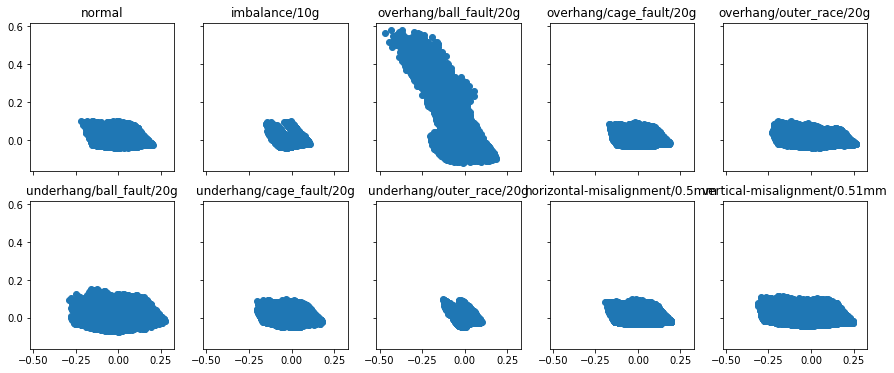

In [23]:
args=ObjectView(get_args(speed=14, folder='normal'))
model=load_model(args)
fig, axs = plt.subplots(2,5,sharex=True,sharey=True,figsize=(15,6))
for count, folder in enumerate(select_folders):
    data=get_dataset(folder=folder, speed=14, experiment_dir=EXPERIMENT_DIR, tensor=True)
    np_data=model.encode(data).detach().numpy()
    axs[count//5, count%5].scatter(np_data[:,0], np_data[:,1])
    axs[count//5, count%5].set_title(folder)
plt.show()
plt.close()

# One model; select folders; speeds 14, 15, 20;  ae + hnn

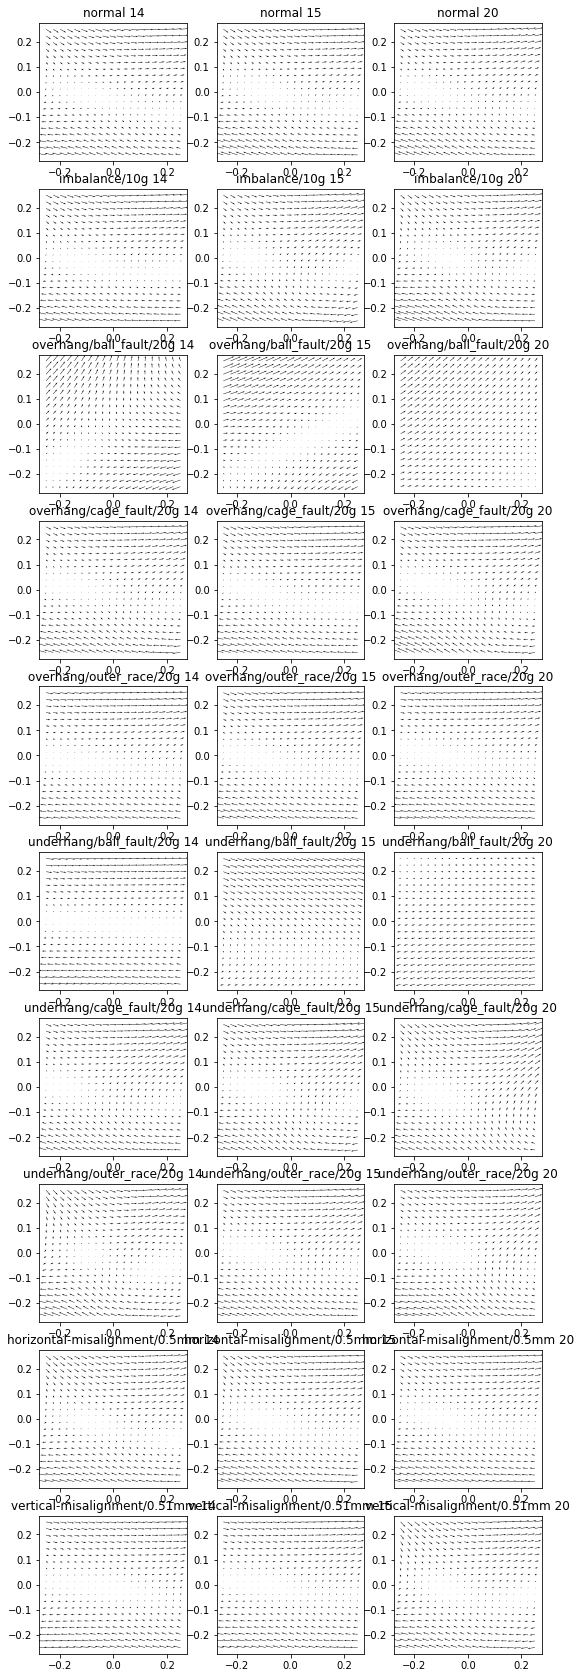

In [8]:
fig, axs = plt.subplots(10,3,figsize=(9,30))
for count_row, folder in enumerate(select_folders):
    for count_column, speed in enumerate(speeds):
        args=ObjectView(get_args(speed, folder))
        model=load_model(args)
        field=get_field(model)
        axs[count_row, count_column].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
        axs[count_row, count_column].set_title('{} {}'.format(folder, speed))
plt.show()

# One model; select folders; speeds 14, 15, 20;  just hnn; speed 14 ae 

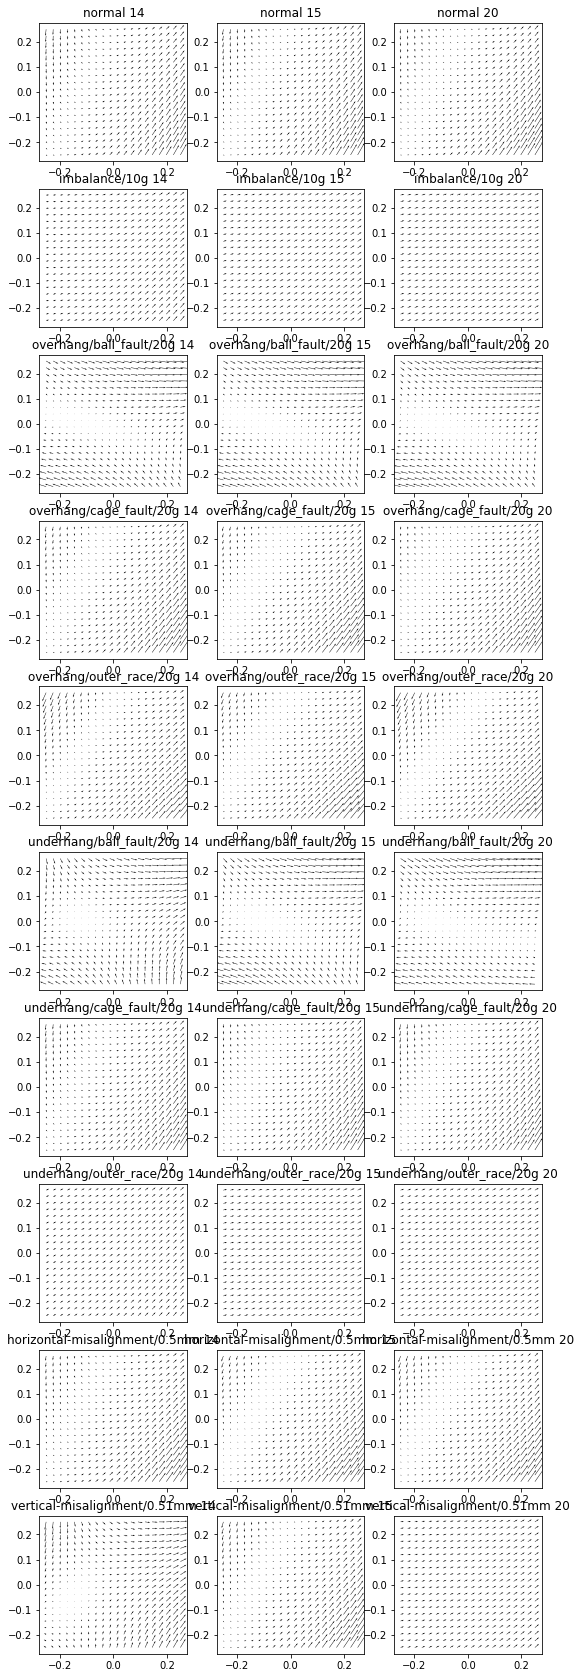

In [9]:
fig, axs = plt.subplots(10,3,figsize=(9,30))
for count_row, folder in enumerate(select_folders):
    for count_column, speed in enumerate(speeds):
        args=ObjectView(get_args(speed, folder, just_hnn=True, ae_path='motor-NORMAL-14-1-pairs'))
        model=load_model(args)
        field=get_field(model)
        axs[count_row, count_column].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
        axs[count_row, count_column].set_title('{} {}'.format(folder, speed))
plt.show()

# One model; select folders; speeds 14, 15, 20;  just hnn; diff speed ae;  

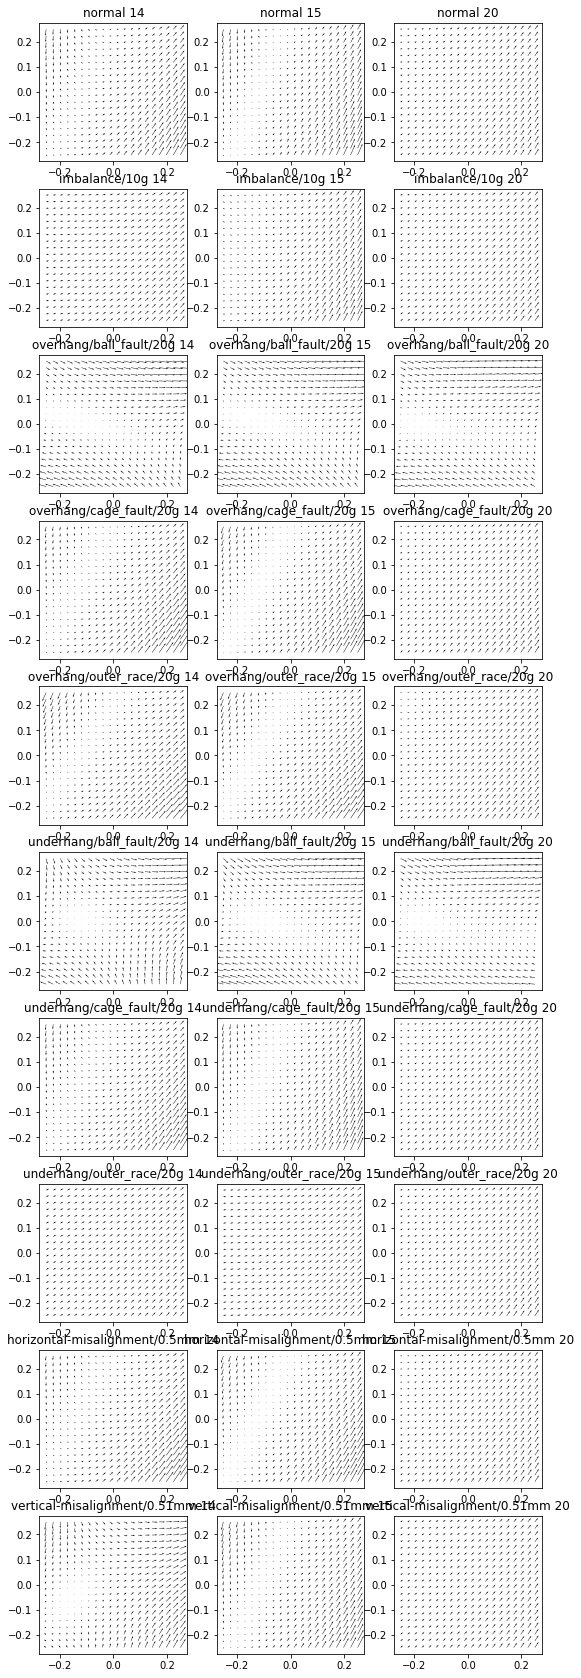

In [10]:
fig, axs = plt.subplots(10,3,figsize=(9,30))
for count_row, folder in enumerate(select_folders):
    for count_column, speed in enumerate(speeds):
        args=ObjectView(get_args(speed, folder, just_hnn=True, ae_path='motor-NORMAL-{}-1-pairs'.format(speed)))
        model=load_model(args)
        field=get_field(model)
        axs[count_row, count_column].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
        axs[count_row, count_column].set_title('{} {}'.format(folder, speed))
plt.show()

# Split models; select folders; speeds 14, 15, 20;  ae + hnn

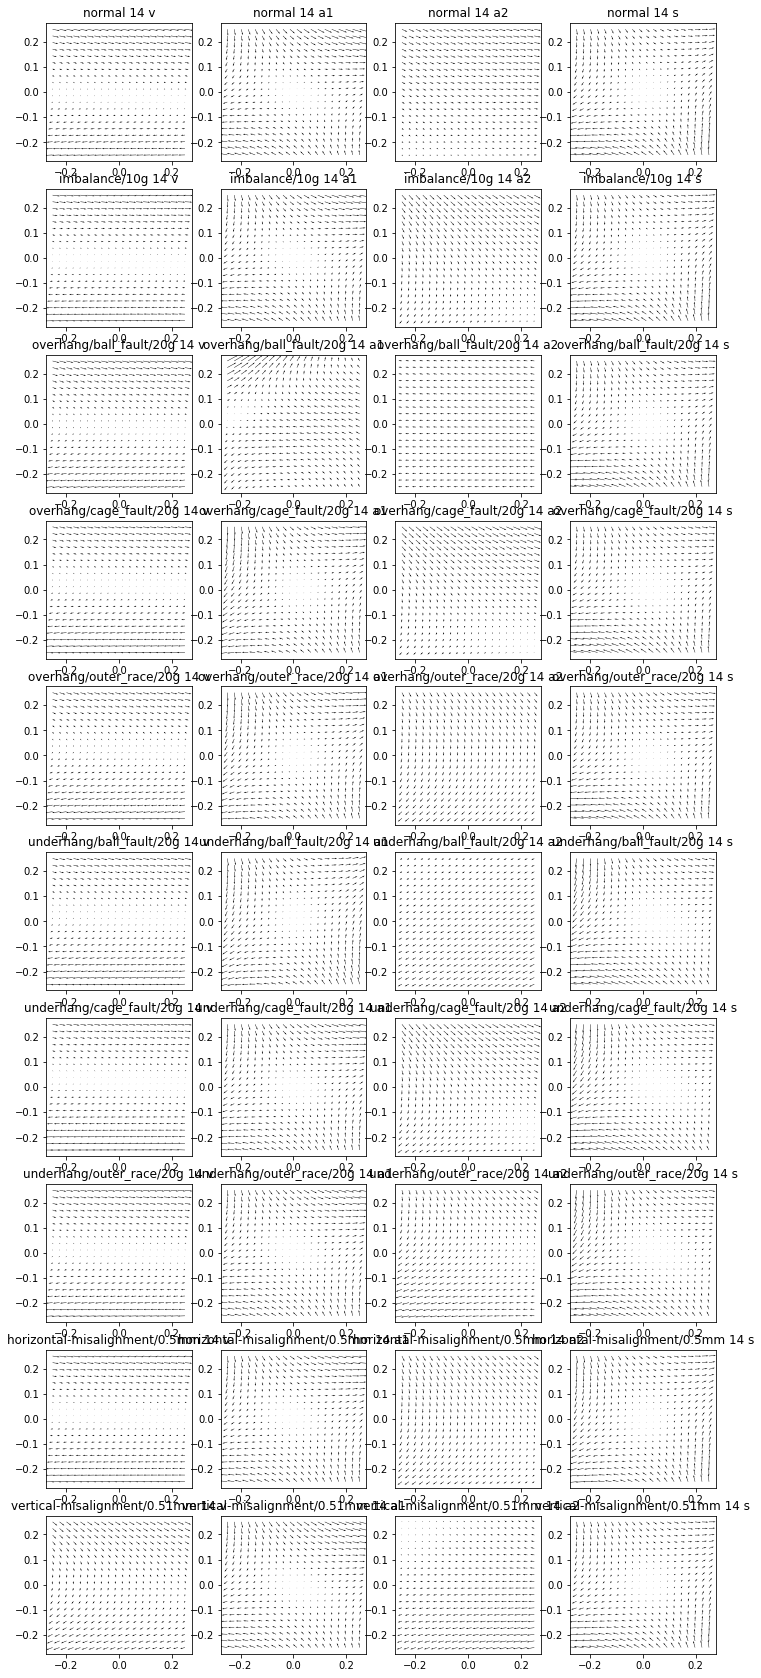

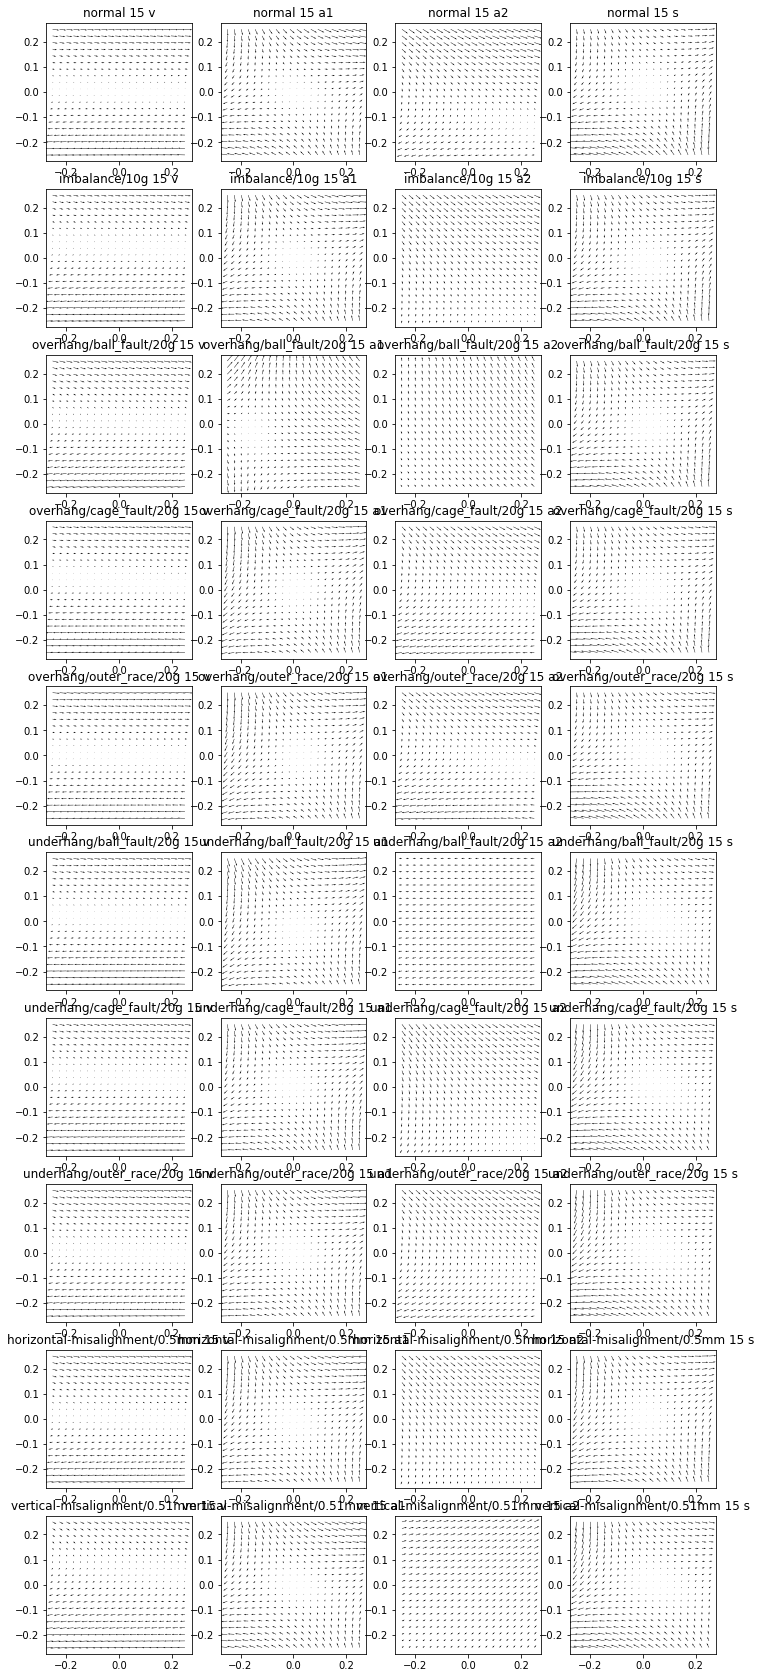

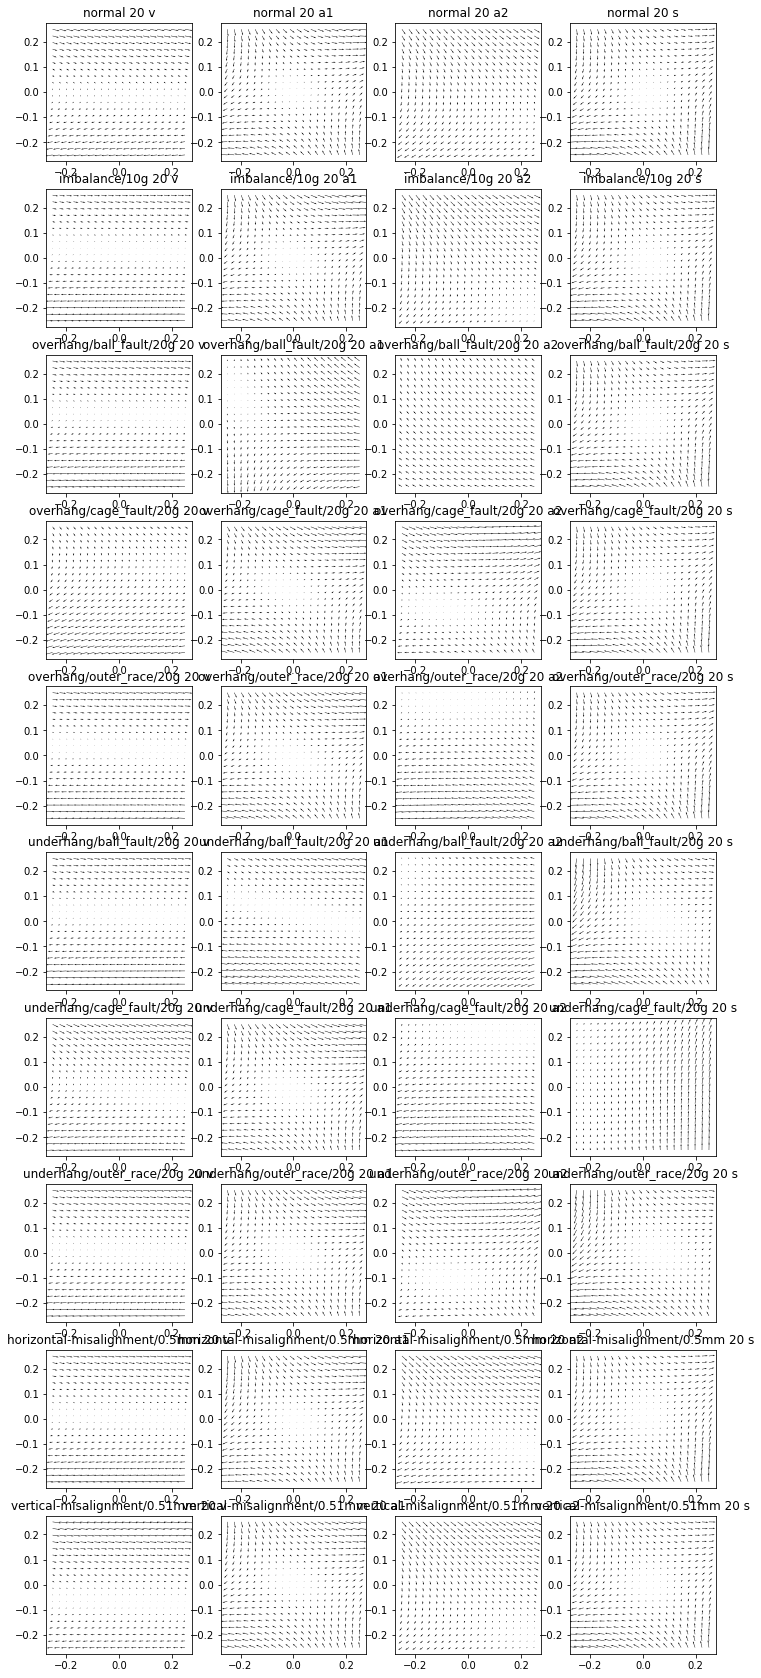

In [11]:
for speed in speeds:
    fig, axs = plt.subplots(10,4,figsize=(12,30))
    for count_row, folder in enumerate(select_folders):
        for col in range(4):
            subcol = ['v', 'a1', 'a2', 's'][col]
            args=ObjectView(get_args(speed, folder))
            model=load_model_col(args, col)
            field=get_field(model)
            axs[count_row, col].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
            axs[count_row, col].set_title('{} {} {}'.format(folder, speed, subcol))
    plt.show()

# Split model; select folders; speeds 14, 15, 20;  just hnn; speed 14 ae

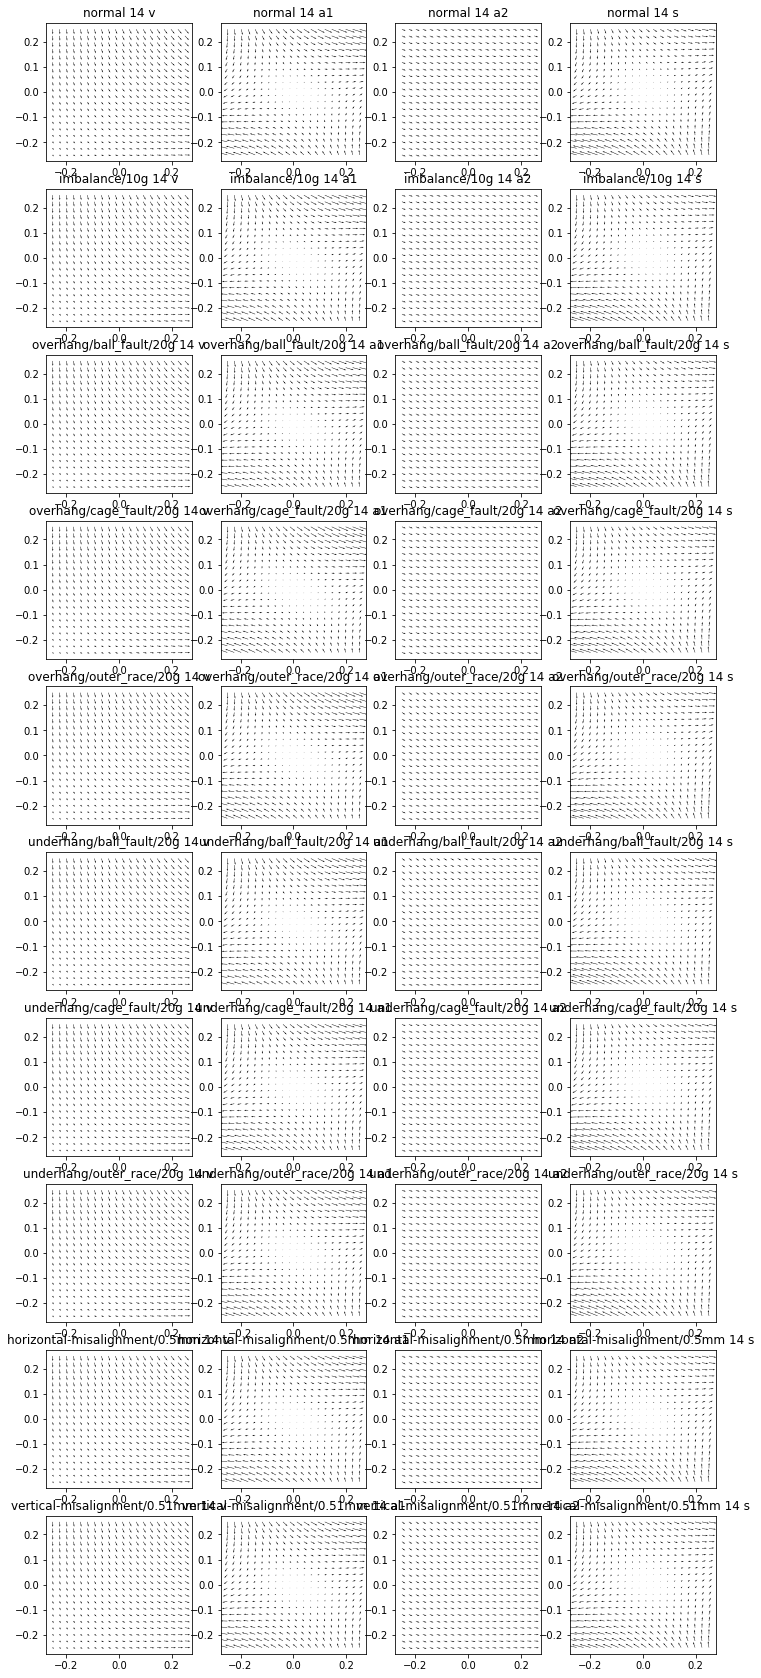

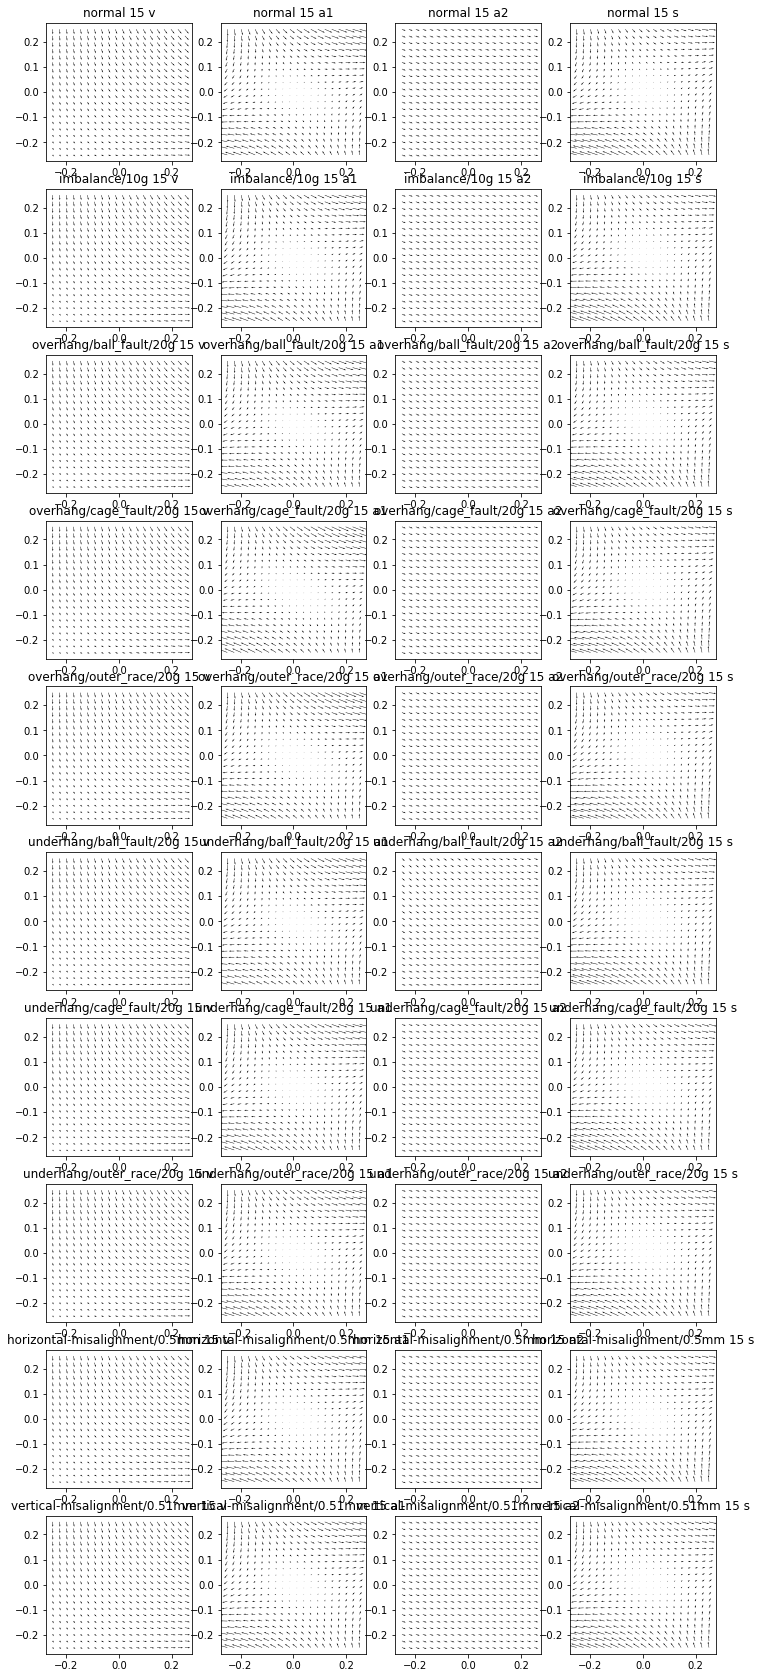

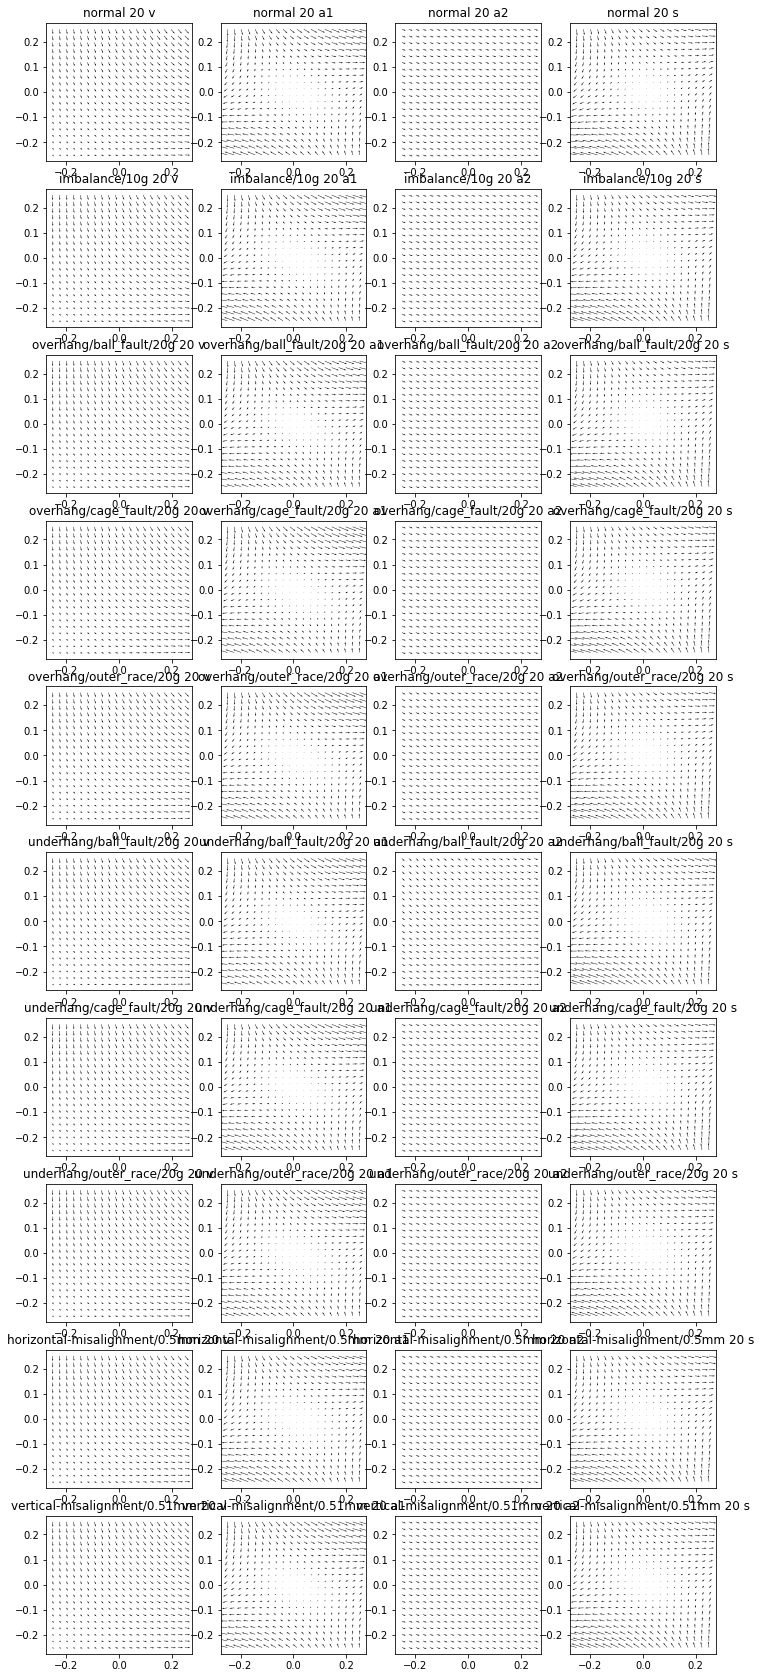

In [12]:
for speed in speeds:
    fig, axs = plt.subplots(10,4,figsize=(12,30))
    for count_row, folder in enumerate(select_folders):
        for col in range(4):
            subcol = ['v', 'a1', 'a2', 's'][col]
            args=ObjectView(get_args(speed, folder, just_hnn=True, ae_path='motor-NORMAL-14-1-pairs'))
            model=load_model_col(args, col)
            field=get_field(model)
            axs[count_row, col].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
            axs[count_row, col].set_title('{} {} {}'.format(folder, speed, subcol))
    plt.show()

# Split model; select folders; speeds 14, 15, 20;  just hnn; diff speed ae

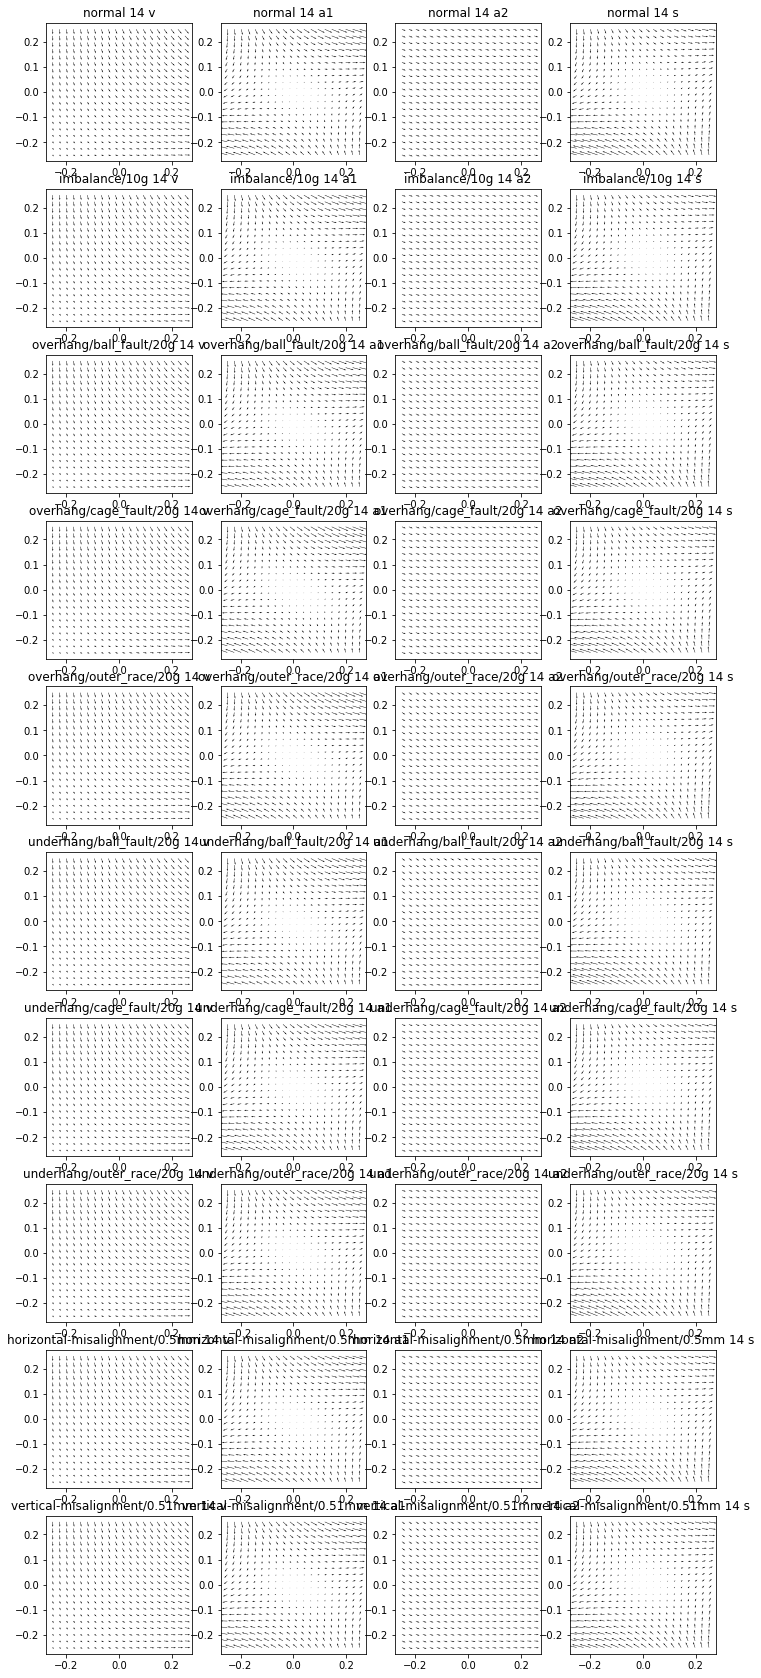

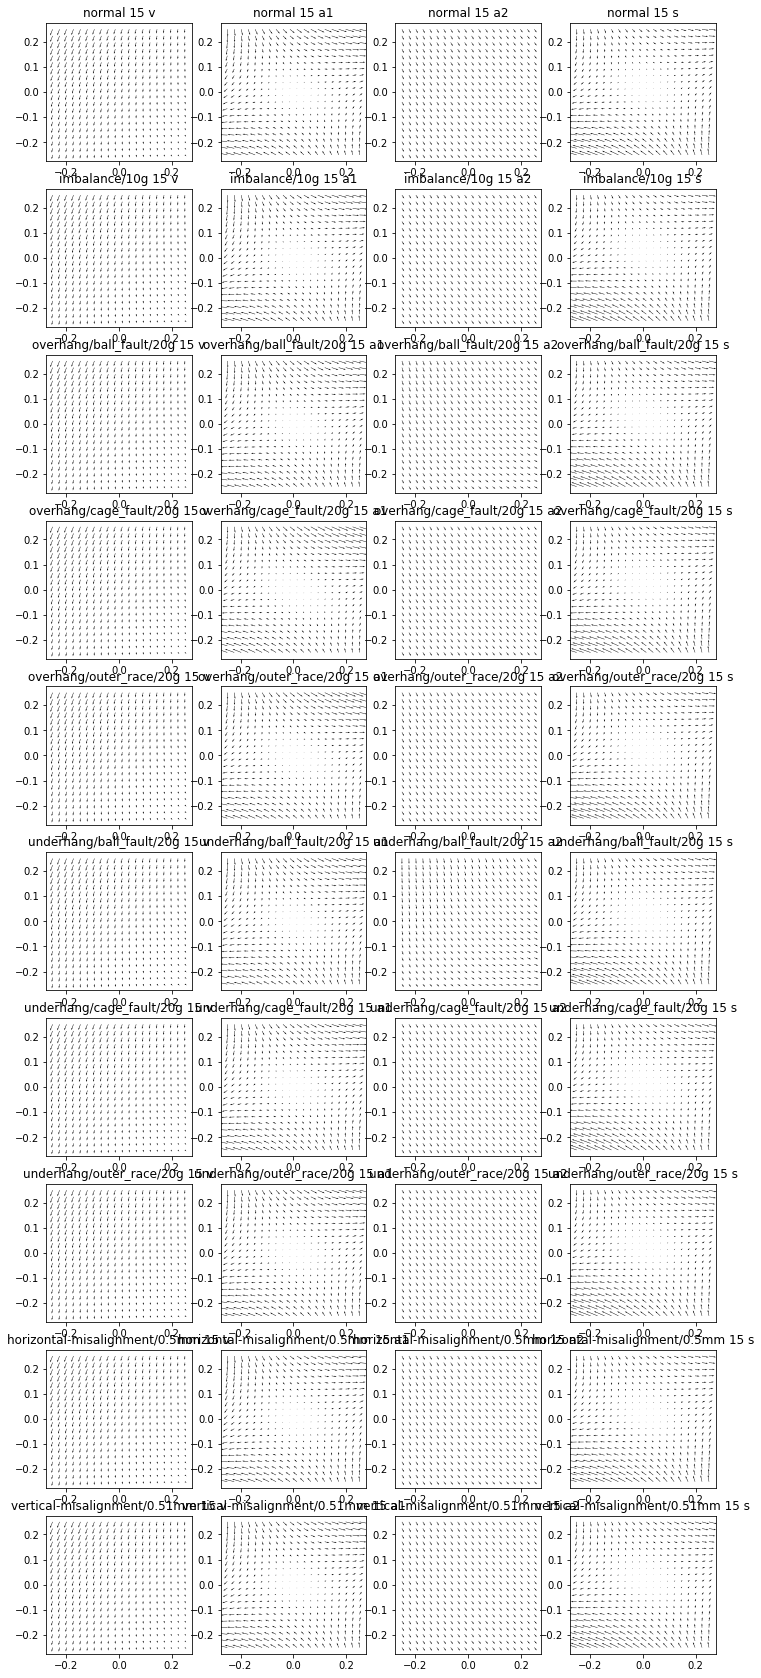

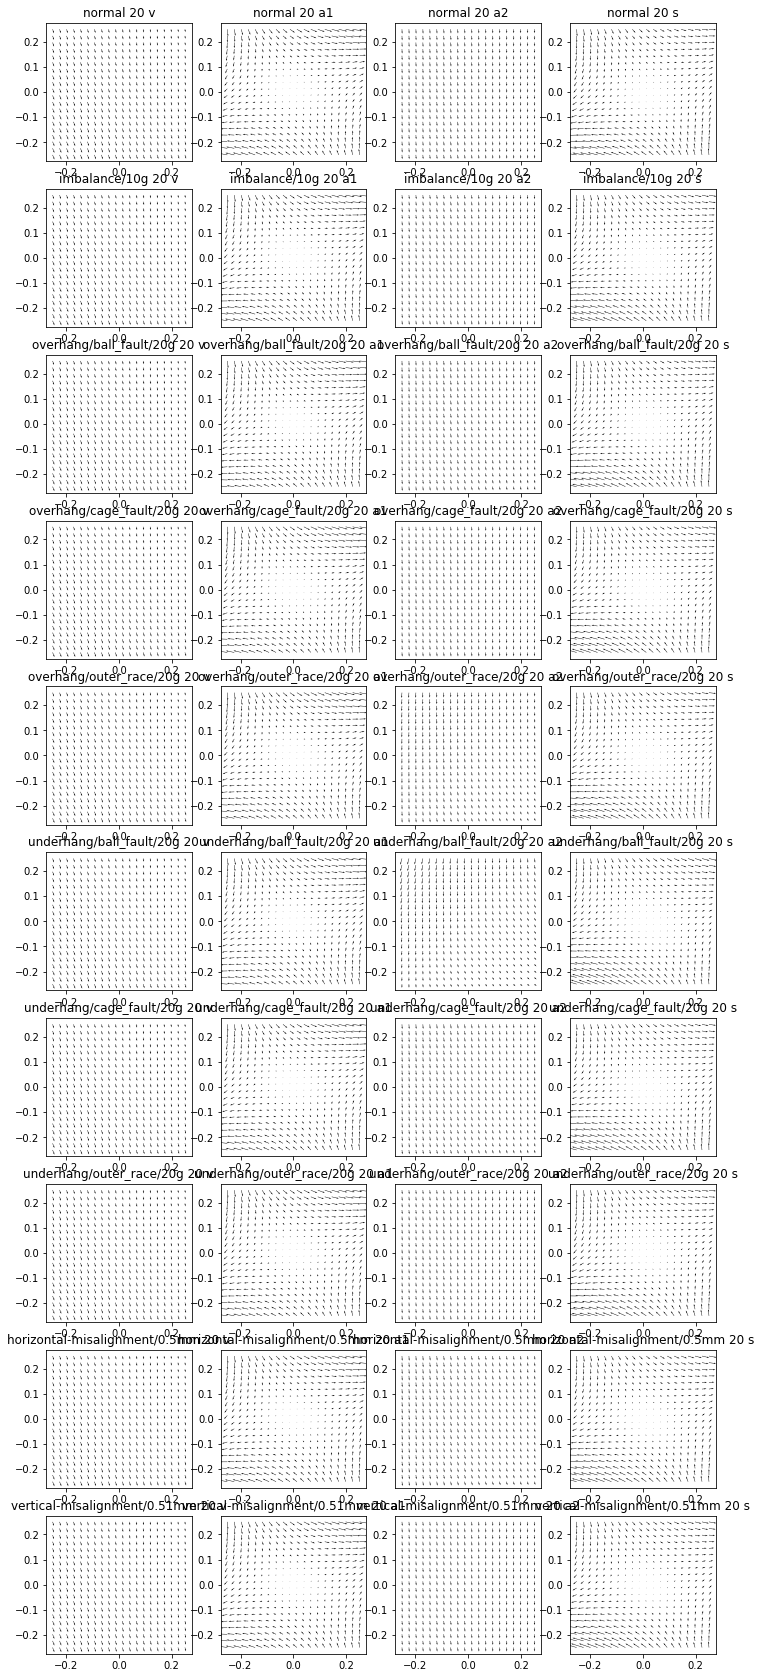

In [13]:
for speed in speeds:
    fig, axs = plt.subplots(10,4,figsize=(12,30))
    for count_row, folder in enumerate(select_folders):
        for col in range(4):
            subcol = ['v', 'a1', 'a2', 's'][col]
            args=ObjectView(get_args(speed, folder, just_hnn=True, ae_path='motor-NORMAL-{}-1-pairs'.format(speed)))
            model=load_model_col(args, col)
            field=get_field(model)
            axs[count_row, col].quiver(field['x'][:,0], field['x'][:,1], field['dx'][:,0], field['dx'][:,1])
            axs[count_row, col].set_title('{} {} {}'.format(folder, speed, subcol))
    plt.show()

In [14]:
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder normal --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 

# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder normal --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 

# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder normal --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 
# !python ./experiment-machine/train.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 

# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --ae_path motor-NORMAL-14-1-pairs

# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-14-1-pairs

# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-14-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-14-1-pairs

# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-15-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-15-1-pairs

# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-20-1-pairs
# !python ./experiment-machine/train-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-20-1-pairs

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --sub_columns 0 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --sub_columns 0 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --sub_columns 0 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --sub_columns 0 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --sub_columns 1 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --sub_columns 1 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --sub_columns 1 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --sub_columns 1 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --sub_columns 2 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --sub_columns 2 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --sub_columns 2 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --sub_columns 2 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --sub_columns 3 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --sub_columns 3 

# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder normal --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --sub_columns 3 
# !python ./experiment-machine/train-multi-dim.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --sub_columns 3 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 0 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 1 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 2 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 14 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-14-1-pairs --sub_columns 3 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 0 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 0 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 1 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 1 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 2 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 2 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 15 --ae_path motor-NORMAL-15-1-pairs --sub_columns 3 

# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder normal --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder imbalance/10g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder overhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/ball_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/cage_fault/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder underhang/outer_race/20g --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder horizontal-misalignment/0.5mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3 
# !python ./experiment-machine/train-multi-dim-hamiltonian.py --experiment_dir ./experiment-machine --folder vertical-misalignment/0.51mm --speed 20 --ae_path motor-NORMAL-20-1-pairs --sub_columns 3
